# Linguistic underpinnings of misinformation

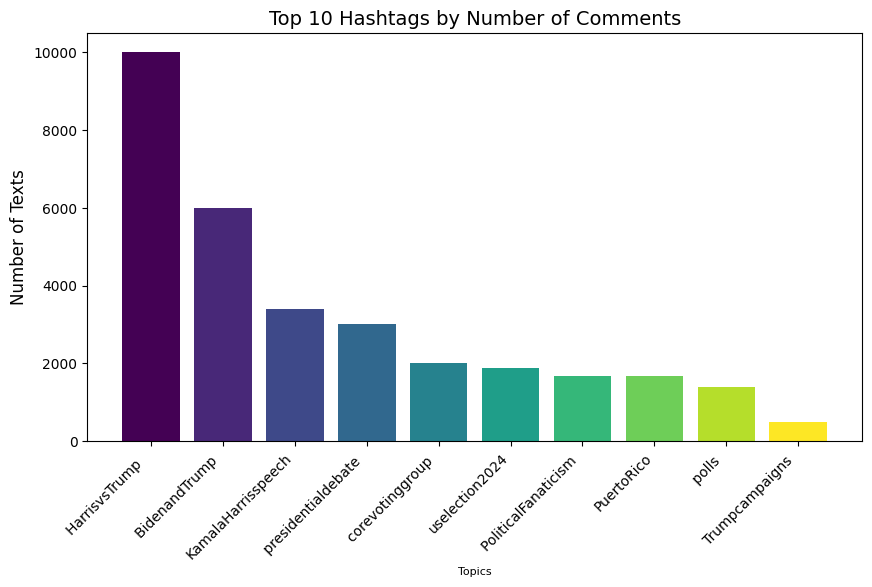

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load your dataset
df = pd.read_csv("DATA/USelection2024.csv")

# Count the number of texts (comments) for each hashtag
hashtag_text_count = df.groupby('hashtags').size().reset_index(name='text_count')

# Sort by text_count in descending order and select the top 10 hashtags
top10_hashtags_text_count = hashtag_text_count.nlargest(10, 'text_count')

# Generate a color for each bar
colors = plt.cm.viridis(np.linspace(0, 1, 10))

# Plot the top 10 hashtags by number of texts in a vertical bar chart
plt.figure(figsize=(10, 6))  # Adjusted figure size for better readability
plt.bar(top10_hashtags_text_count['hashtags'], top10_hashtags_text_count['text_count'], color=colors)

# Add titles and labels
plt.title("Top 10 Hashtags by Number of Comments", fontsize=14)
plt.xlabel("Topics", fontsize=8)
plt.ylabel("Number of Texts", fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.subplots_adjust(bottom=0.2) 
plt.savefig('plot_image1.png')
# Show the plot
plt.show()




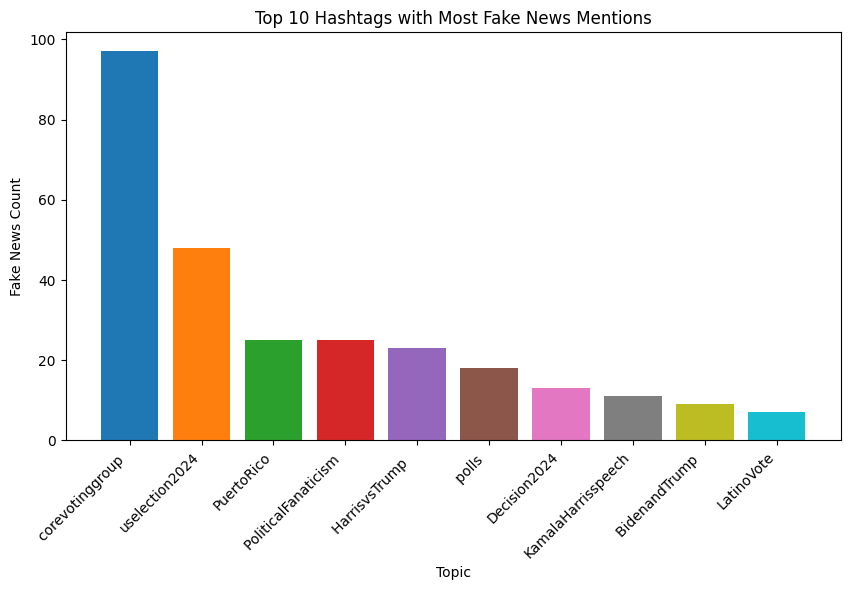

In [8]:
import matplotlib.pyplot as plt

# Define keywords that indicate fake news
fake_news_keywords = ["fake news", "misinformation",'voterfraud', 'discardedballots',
 'cheatingdemocrats', 'stopvoterfraud',
 'voterfraudbymail', 'voterfraudisreal',
 'ballotharvasting', 'ballotvoterfraud']

# Filter rows where 'cleaned_text' contains fake news keywords
fake_news_df = df[df['text'].str.contains('|'.join(fake_news_keywords), case=False, na=False)]

# Group by 'hashtags' and count occurrences for each hashtag
fake_news_counts = fake_news_df['hashtags'].value_counts().reset_index()
fake_news_counts.columns = ['hashtags', 'fake_news_count']

# Select the top 10 hashtags with the most fake news mentions
top10_fake_news = fake_news_counts.nlargest(10, 'fake_news_count')

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(top10_fake_news['hashtags'], top10_fake_news['fake_news_count'], color=plt.cm.tab10.colors)
plt.title("Top 10 Hashtags with Most Fake News Mentions")
plt.xlabel("Topic")
plt.ylabel("Fake News Count")
plt.xticks(rotation=45,ha='right')
plt.subplots_adjust(bottom=0.2) 
plt.savefig('Fakenews.png')
plt.show()


In [3]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Load your dataset
df = pd.read_csv("DATA/USelection2024.csv")

# Clean any extra spaces in column names (if needed)
df.columns = df.columns.str.strip()

# Calculate the number of texts (comments) per hashtag
hashtag_text_count = df.groupby('hashtags').size().reset_index(name='text_count')

# Calculate the mean like_count per hashtag
hashtag_like_count = df.groupby('hashtags')['like_count'].mean().reset_index(name='average_like_count')

# Merge these two DataFrames on 'hashtags' to create a single DataFrame for analysis
hashtag_data = pd.merge(hashtag_text_count, hashtag_like_count, on='hashtags')

# Run the regression model on the aggregated data
model = ols("average_like_count ~ text_count", data=hashtag_data).fit()

# Extract values for Coefficient, Standard Error, T-score, and P-value for 'text_count'
results_table = pd.DataFrame({
    "Statistic": ["Coefficient", "Standard Error", "T-score", "P-value"],
    "Value": [
        model.params['text_count'],
        model.bse['text_count'],
        model.tvalues['text_count'],
        model.pvalues['text_count']
    ]
})

# Display the table
print(results_table)


        Statistic     Value
0     Coefficient  0.000612
1  Standard Error  0.000281
2         T-score  2.180497
3         P-value  0.046777


# K- means cluster formation

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Load the dataset
file_path = 'DATA/USelection2024.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Sample a subset if the dataset is large (e.g., 5000 rows)
data_sample = data.sample(5000, random_state=42) if len(data) > 5000 else data

# Combine the 'text' and 'hashtags' columns for clustering
data_sample['text_combined'] = data_sample['text'] + " " + data_sample['hashtags']

# Vectorize the combined text data using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
text_vectors = vectorizer.fit_transform(data_sample['text_combined'].fillna('')).toarray()

# Apply K-means with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)
data_sample['cluster'] = kmeans.fit_predict(text_vectors)

# Determine which cluster represents each supporter group
# For simplicity, assign names based on word frequencies
cluster_0_text = " ".join(data_sample[data_sample['cluster'] == 0]['text_combined'])
cluster_1_text = " ".join(data_sample[data_sample['cluster'] == 1]['text_combined'])

# Assign names based on the presence of keywords
if "Trump" in cluster_0_text:
    cluster_names = {0: "Trump Supporters", 1: "Kamala Harris Supporters"}
else:
    cluster_names = {1: "Trump Supporters", 0: "Kamala Harris Supporters"}

# Reduce dimensions to 2D using PCA for visualization
pca = PCA(n_components=2, random_state=42)
reduced_vectors = pca.fit_transform(text_vectors)

# Plot the clusters
plt.figure(figsize=(10, 6))
for cluster_id, cluster_name in cluster_names.items():
    indices = data_sample['cluster'] == cluster_id
    plt.scatter(reduced_vectors[indices, 0], reduced_vectors[indices, 1], label=cluster_name, alpha=0.5)


plt.title('K-means Clustering of Supporter')
plt.legend()
plt.colorbar(label='Cluster')
plt.subplots_adjust(bottom=0.2) 
plt.savefig('Kmeans.png')
plt.show()



# Effect of echo chamber


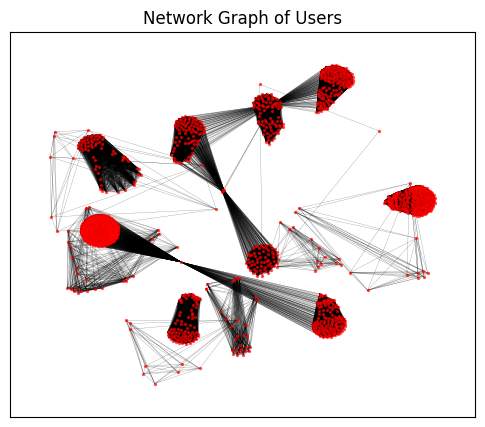

In [9]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

# Load the dataset from the DATA folder
df = pd.read_csv('DATA/uselection2024.csv')

# Take a smaller random sample from the dataset
small_subset = df.sample(n=1500, random_state=42)  # Adjust n for sample size

# Initialize an empty graph
G = nx.Graph()

# Group by hashtags and connect users who share the same hashtag
for hashtag, group in small_subset.groupby('hashtags'):
    authors = group['author'].dropna().unique()  # Unique authors for each hashtag
    # Add edges between each pair of users in the group
    for author1, author2 in combinations(authors, 2):
        if G.has_edge(author1, author2):
            G[author1][author2]['weight'] += 1  # Increment weight for shared hashtag
        else:
            G.add_edge(author1, author2, weight=1)

# Draw the network
plt.figure(figsize=(6, 5))
pos = nx.spring_layout(G, k=0.3)
nx.draw_networkx_nodes(G, pos, node_size=2, node_color="red", alpha=0.6)
nx.draw_networkx_edges(G, pos, width=0.2, alpha=0.5)
plt.title("Network Graph of Users")
plt.show()


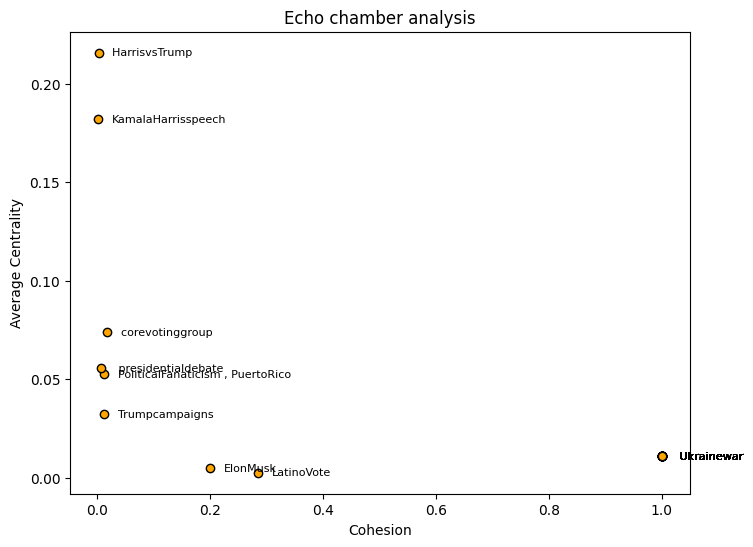

In [10]:
import pandas as pd
import networkx as nx
from collections import defaultdict
from itertools import combinations
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'DATA/USelection2024.csv'
data = pd.read_csv(file_path)

# Step 1: Reduce Graph Size by Filtering Inactive Users

active_data = data[data['like_count'] > 5]  

# Step 2: Build User Interaction Graph with Shared Hashtags for Filtered Data
G = nx.Graph()
hashtag_to_authors = defaultdict(list)

for _, row in active_data.iterrows():
    author = row['author']
    hashtag = row['hashtags']
    hashtag_to_authors[hashtag].append(author)

for authors in hashtag_to_authors.values():
    for author1, author2 in combinations(authors, 2):
        if G.has_edge(author1, author2):
            G[author1][author2]['weight'] += 1
        else:
            G.add_edge(author1, author2, weight=1)

# Step 3: Faster Community Detection (Label Propagation)
from networkx.algorithms.community import label_propagation_communities
communities = list(label_propagation_communities(G))

# Store community data in a dictionary
community_dict = {i: list(community) for i, community in enumerate(communities)}

# Step 4: Calculate Degree Centrality Instead of Betweenness Centrality
# Degree centrality is simpler and faster to compute
centrality = nx.degree_centrality(G)

# Step 5: Limit TF-IDF Features for Text Processing
text_data = active_data['text'] + ' ' + active_data['hashtags']
vectorizer = TfidfVectorizer(max_features=200)  # Reduced feature count
X = vectorizer.fit_transform(text_data)

# Step 6: Incrementally Process Each Community to Calculate Metrics
echo_chambers_influence = []

# Dictionary to store the most common hashtags for each community
community_hashtags = {}

for community_id, nodes in community_dict.items():
    # Create a subgraph for the community
    subgraph = G.subgraph(nodes)

    # Calculate average degree centrality for influence measure
    avg_centrality = np.mean([centrality[node] for node in nodes])

    # Calculate average like count for engagement measure
    community_data = active_data[active_data['author'].isin(nodes)]
    avg_likes = community_data['like_count'].mean()

    # Calculate cohesion based on hashtag diversity within the community
    hashtags = set(community_data['hashtags'])
    cohesion = len(hashtags) / len(nodes) if len(nodes) > 0 else 0

    # Determine the most common hashtags for this community
    common_hashtags = community_data['hashtags'].mode()[:3]  # Top 3 most common hashtags

    # Store the community's hashtag data
    community_hashtags[community_id] = common_hashtags.tolist()

    # Store metrics for each community
    echo_chambers_influence.append({
        "community_id": community_id,
        "members_count": len(nodes),
        "avg_centrality": avg_centrality,
        "avg_likes": avg_likes,
        "cohesion": cohesion,
        "hashtags": common_hashtags.tolist()  # Most common hashtags
    })

# Display a summary of the echo chambers with their influence metrics
# for chamber in echo_chambers_influence[:10]:  # Display only first 10 for brevity
#     print(f"Community {chamber['community_id']} - Users: {chamber['members_count']}")
#     print(f" - Average Centrality: {chamber['avg_centrality']}")
#     print(f" - Average Likes: {chamber['avg_likes']}")
#     print(f" - Cohesion: {chamber['cohesion']}")
#     print(f" - Top Hashtags: {', '.join(chamber['hashtags'])}")
#     print("-----------")

# Optional Plot: Cohesion vs Centrality Scatter Plot
cohesions = [chamber["cohesion"] for chamber in echo_chambers_influence]
avg_centralities = [chamber["avg_centrality"] for chamber in echo_chambers_influence]
hashtags = [', '.join(chamber["hashtags"]) for chamber in echo_chambers_influence]

plt.figure(figsize=(8, 6))
plt.scatter(cohesions, avg_centralities, c="orange", edgecolor="k")

for i, chamber in enumerate(echo_chambers_influence):
    hashtags_str = ', '.join(chamber['hashtags'])  # Join the hashtags as a string with commas
    plt.annotate(hashtags_str,  # Use the joined string
                 (cohesions[i], avg_centralities[i]),  # Point location
                 xytext=(10, 0),  # Adjust the position of the text (move it to the right by 10 units)
                 textcoords='offset points',  # Specify that the offset is in points
                 fontsize=8, ha='left', va='center')  # Align the text to the left of the point

plt.xlabel("Cohesion")
plt.ylabel("Average Centrality")
plt.title("Echo chamber analysis")
plt.show()



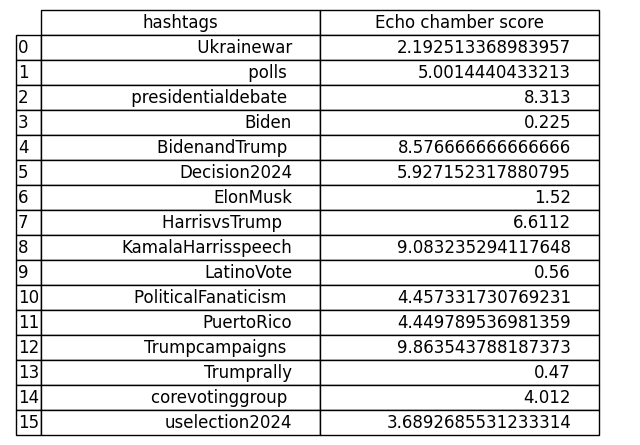

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import table

# Import the database
df = pd.read_csv("DATA/USelection2024.csv")

# Calculate average engagement within each hashtag cluster
hashtag_engagement = df.groupby('hashtags')['like_count'].mean().reset_index()
hashtag_engagement.columns = ['hashtags', 'Echo chamber score']

# Calculate overall average engagement
overall_avg_engagement = df['like_count'].mean()

# Display results in the console
# print("Quantifying Echo Chamber Strength:\n", hashtag_engagement)
# print("\nOverall Average Strength:", overall_avg_engagement)

# Plotting the table using Matplotlib
fig, ax = plt.subplots(figsize=(8, 4))  # Set the figure size
ax.axis('off')  # Hide axes

# Create a table and add it to the figure
tbl = table(ax, hashtag_engagement, loc='center', colWidths=[0.3, 0.3])  # Adjust column widths
tbl.auto_set_font_size(False)  # Disable auto font size
tbl.set_fontsize(12)  # Set font size for the table
tbl.scale(1.5, 1.5)  # Scale the table for better visibility

# Add overall average engagement as a note
# plt.figtext(0.5, 0.01, f"Overall Average Engagement: {overall_avg_engagement:.2f}", ha="center", fontsize=12)

# Save the figure as an image
plt.savefig("Echo_Chamber_Strength.png", bbox_inches='tight', dpi=300)

# Optionally, display the table in a window (you can comment this out if not needed)
plt.show()


